In [55]:
%matplotlib inline

%astropy

import matplotlib.pyplot as plt

from astropy.modeling import models, fitting
from astropy.stats import sigma_clipped_stats
from photutils import datasets, DAOStarFinder, CircularAperture

Numpy 1.16.0
Astropy 3.2.dev23778


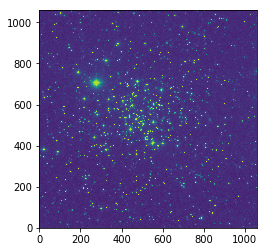

In [4]:
hdu = datasets.load_star_image()
plt.imshow(hdu.data, origin='lower')

In [185]:
data = hdu.data[400:600,0:200]

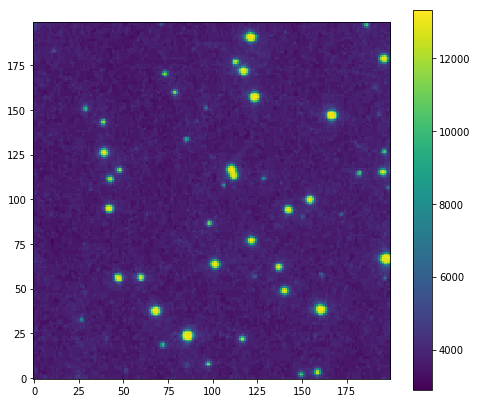

In [186]:
plt.figure(figsize=(8,7))
plt.imshow(data, origin='lower')
plt.colorbar()

In [187]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
mean, median, std

(3733.509624537282, 3720.0, 205.8880934391474)

In [188]:
daofind = DAOStarFinder(fwhm=5.0, threshold=5.*std, exclude_border=True)    
sources = daofind(data - median)    
for col in sources.colnames:    
    sources[col].info.format = '%.8g'  # for consistent table output

In [189]:
sources[:2]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,158.47309,3.3038949,0.56232331,-0.10077111,-0.030274457,49,0,8777,13.136336,-2.7961856
2,51.33242,4.5117897,0.83473835,-0.42850097,0.26336071,49,0,998,1.3291533,-0.30893767


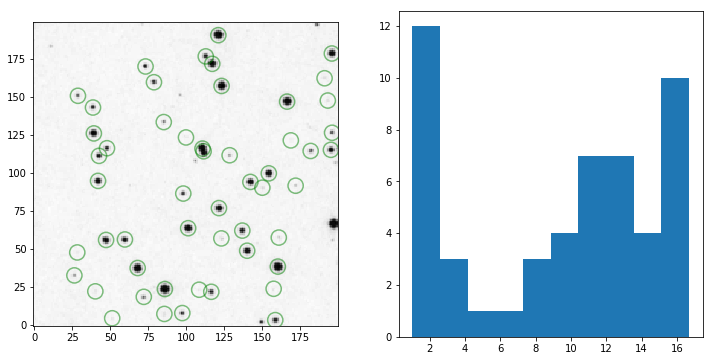

In [190]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=5.)
#norm = ImageNormalize(stretch=SqrtStretch())
ax1.imshow(data, cmap='Greys', origin='lower')
apertures.plot(color='green', lw=1.5, alpha=0.5, ax=ax1)

ax2.hist(sources['flux']);

In [191]:
len(sources)

52

In [192]:
sources.sort('flux')
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
10,157.42372,23.890435,0.69229719,0.49582928,-0.062582372,49,0,703,1.0102818,-0.011106346
14,28.376799,47.770306,0.73058041,0.051912093,0.19264977,49,0,805,1.0117096,-0.012639695
8,108.48305,23.280401,0.70403714,0.3329071,-0.41637446,49,0,652,1.0304561,-0.032573761
36,168.70714,121.40323,0.33495824,-0.013587771,0.10918726,49,0,317,1.0368361,-0.039275241
37,99.810524,123.34158,0.70958454,-0.48368532,-0.085584649,49,0,743,1.117579,-0.12069561
2,51.33242,4.5117897,0.83473835,-0.42850097,0.26336071,49,0,998,1.3291533,-0.30893767
6,40.246007,22.211554,0.61875071,0.23844834,0.54410908,49,0,1009,1.3808207,-0.35034325
47,190.88592,162.22471,0.45303065,-0.11049452,0.1622305,49,0,958,1.5729599,-0.49179415
43,193.00819,147.58745,0.73780219,0.39111332,0.32629065,49,0,1389,1.7315568,-0.59609186


In [193]:
def tied_xstd(g):
    return g[0].x_stddev
def tied_ystd(g):
    return g[0].y_stddev

model = None
for s in sources:
    m = models.Gaussian2D(amplitude=s['peak'], x_mean=s['xcentroid'], y_mean=s['ycentroid'], x_stddev=5, y_stddev=5, theta=0)
    m.theta.fixed = True
    m.amplitude.bounds = (0, 1e6)
    
    if model is None:
        model = m
    else:
        m.x_stddev.tied = tied_xstd
        m.y_stddev.tied = tied_ystd
        model += m

In [194]:
ny, nx = data.shape

In [195]:
yy, xx = np.mgrid[:ny, :nx]

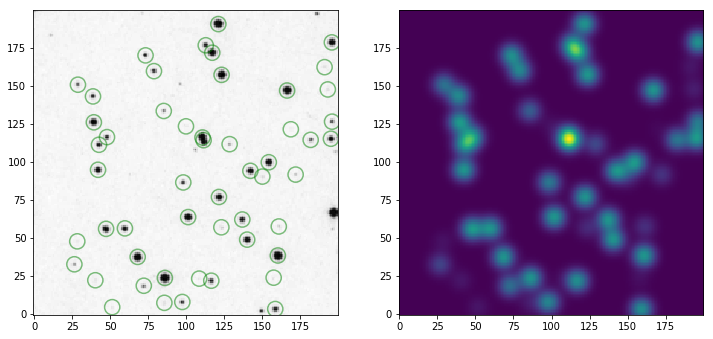

In [196]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=5.)
#norm = ImageNormalize(stretch=SqrtStretch())
ax1.imshow(data, cmap='Greys', origin='lower')
apertures.plot(color='green', lw=1.5, alpha=0.5, ax=ax1)

ax2.imshow(model(xx, yy), origin='lower')

In [197]:
fitter = fitting.LevMarLSQFitter()

In [198]:
res = fitter(model, xx, yy, data - median, maxiter=1000)

In [199]:
fitter.fit_info

{'nfev': 1117,
 'fvec': array([  91.,   91.,  182., ...,    6., -153., -153.]),
 'fjac': array([[-8.12024779e+04, -2.72676953e+04,  5.92677403e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.73703990e+04, -7.40693694e+04, -1.19938450e+01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.94909722e-01, -1.20513362e+01, -1.79015235e+04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 'ipvt': array([  5,   4,  71,  70,  83,  95,  82, 101,  94, 100, 116,  86, 113,
        115,  85, 112, 122, 121, 137, 136, 125, 149, 124, 14

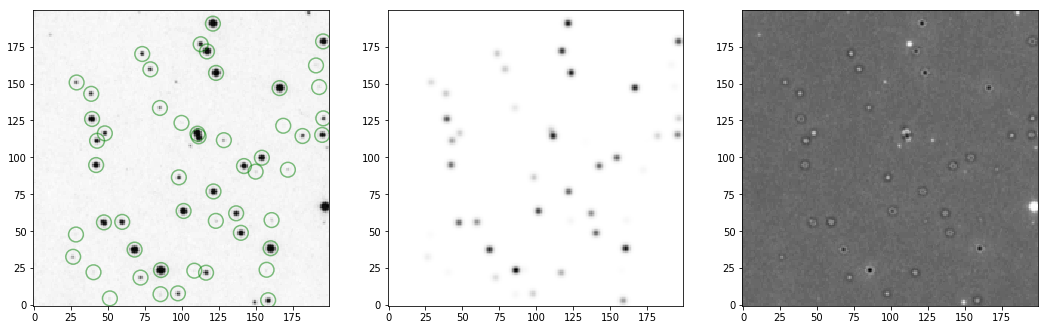

In [200]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=5.)
#norm = ImageNormalize(stretch=SqrtStretch())
ax1.imshow(data, cmap='Greys', origin='lower')
apertures.plot(color='green', lw=1.5, alpha=0.5, ax=ax1)

ax2.imshow(res(xx, yy), cmap='Greys', origin='lower')

ax3.imshow(res(xx, yy) - (data-median), cmap='Greys', origin='lower')

In [201]:
res.n_submodels()

52

In [202]:
list(res)

[<Gaussian2D(amplitude=331.81275986, x_mean=157.38387103, y_mean=23.639123, x_stddev=1.87342168, y_stddev=1.82627586, theta=0.)>,
 <Gaussian2D(amplitude=488.1479378, x_mean=28.20650062, y_mean=47.62513212, x_stddev=1.87342168, y_stddev=1.82627586, theta=0.)>,
 <Gaussian2D(amplitude=762.90753862, x_mean=91.67357256, y_mean=24.13443635, x_stddev=1.87342168, y_stddev=1.82627586, theta=0.)>,
 <Gaussian2D(amplitude=81.92240846, x_mean=174.50832108, y_mean=111.15621567, x_stddev=1.87342168, y_stddev=1.82627586, theta=0.)>,
 <Gaussian2D(amplitude=3829.13917368, x_mean=109.65783232, y_mean=118.52389406, x_stddev=1.87342168, y_stddev=1.82627586, theta=0.)>,
 <Gaussian2D(amplitude=0., x_mean=49.40912581, y_mean=0.84433261, x_stddev=1.87342168, y_stddev=1.82627586, theta=0.)>,
 <Gaussian2D(amplitude=711.89648428, x_mean=40.10780638, y_mean=22.14940342, x_stddev=1.87342168, y_stddev=1.82627586, theta=0.)>,
 <Gaussian2D(amplitude=908.71417006, x_mean=190.94974854, y_mean=162.4322172, x_stddev=1.873